# AquaYOLO model for Underwater Object Detection

This is a replication of the model/architecture purposed in **AquaYOLO: Enhancing YOLOv8 for Accurate Underwater Object Detection for Sonar Images**. The paper can be found at [this link](https://www.mdpi.com/2077-1312/13/1/73). 

## Dataset Setup

Using the UATD dataset:

- Download the dataset from [here](hhttps://figshare.com/articles/dataset/UATD_Dataset/21331143/3). Download all 4 zips.
- Create ./data folder within the model. (Like this: ./aqua_yolo/data)
- Place the downloaded .zip files inside the data-folder
- Then unzip them manually or running code below:

In [1]:
import zipfile
import os

zip_paths = ["data/UATD_OpenSLT.zip", "data/UATD_Test_1.zip", "data/UATD_Test_2.zip", "data/UATD_Training.zip",]
extract_dir = "data/UATD/"

# Make sure the target directory exists
os.makedirs(extract_dir, exist_ok=True)

for zip_path in zip_paths:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(zip_path, " extracted to:", os.path.abspath(extract_dir))

data/UATD_OpenSLT.zip  extracted to: /Users/henrik/kode/SP/aqua_yolo/data/UATD
data/UATD_Test_1.zip  extracted to: /Users/henrik/kode/SP/aqua_yolo/data/UATD
data/UATD_Test_2.zip  extracted to: /Users/henrik/kode/SP/aqua_yolo/data/UATD
data/UATD_Training.zip  extracted to: /Users/henrik/kode/SP/aqua_yolo/data/UATD


### Setup on YOLO format

In [4]:
# Set up the paths

from pathlib import Path

ROOT = Path.cwd()
DATA = ROOT / "data" / "UATD"

UATD_TRAIN = DATA / "UATD_Training"
UATD_VAL   = DATA / "UATD_Test_1"
UATD_TEST  = DATA / "UATD_Test_2"

# YOLO folders directly inside UATD/
YOLO_IMG = DATA / "images"
YOLO_LBL = DATA / "labels"

# Create standard YOLO directory tree
for split in ["train", "val", "test"]:
    (YOLO_IMG / split).mkdir(parents=True, exist_ok=True)
    (YOLO_LBL / split).mkdir(parents=True, exist_ok=True)

print("✅ YOLO structure ready at:", DATA)


✅ YOLO structure ready at: /Users/henrik/kode/SP/aqua_yolo/data/UATD


In [5]:
# Convert XMLs → YOLO labels

import glob, shutil
from xml.etree import ElementTree as ET

SPLIT_MAP = {
    "train": UATD_TRAIN,
    "val":   UATD_VAL,
    "test":  UATD_TEST,
}

def parse_box(obj):
    bb = obj.find("bndbox")
    return (
        float(bb.findtext("xmin")),
        float(bb.findtext("ymin")),
        float(bb.findtext("xmax")),
        float(bb.findtext("ymax")),
    )

def voc_to_yolo(xmin, ymin, xmax, ymax, w, h):
    cx = ((xmin + xmax) / 2) / w
    cy = ((ymin + ymax) / 2) / h
    bw = (xmax - xmin) / w
    bh = (ymax - ymin) / h
    return cx, cy, bw, bh

def sanitize(name: str):
    return name.strip().replace(" ", "-").lower()

def convert_to_yolo():
    class_to_id, classes = {}, []

    for split, src_dir in SPLIT_MAP.items():
        ann_dir = src_dir / "annotations"
        img_dir = src_dir / "images"
        xmls = sorted(glob.glob(str(ann_dir / "*.xml")))
        print(f"[{split}] Found {len(xmls)} XMLs")

        for xml in xmls:
            root = ET.parse(xml).getroot()
            w = int(root.find("size").findtext("width"))
            h = int(root.find("size").findtext("height"))
            fname = root.find("file").findtext("filename") or Path(xml).stem
            stem = Path(fname).stem
            img_src = img_dir / f"{stem}.bmp"

            if not img_src.exists():
                print(f"⚠️ Missing image for {stem}.bmp")
                continue

            # Write YOLO label
            lbl_path = YOLO_LBL / split / f"{stem}.txt"
            with open(lbl_path, "w") as y:
                for obj in root.findall("object"):
                    cname = sanitize(obj.findtext("name"))
                    if cname not in class_to_id:
                        class_to_id[cname] = len(classes)
                        classes.append(cname)
                    cls_id = class_to_id[cname]
                    xmin, ymin, xmax, ymax = parse_box(obj)
                    cx, cy, bw, bh = voc_to_yolo(xmin, ymin, xmax, ymax, w, h)
                    y.write(f"{cls_id} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}\n")

            # Copy image to YOLO folder
            dst_img = YOLO_IMG / split / img_src.name
            if not dst_img.exists():
                shutil.copy2(img_src, dst_img)

    print("✅ Conversion complete.")
    print("Classes:", classes)
    return classes

CLASSES = convert_to_yolo()


[train] Found 7600 XMLs
[val] Found 800 XMLs
[test] Found 800 XMLs
✅ Conversion complete.
Classes: ['human-body', 'ball', 'circle-cage', 'square-cage', 'tyre', 'metal-bucket', 'cube', 'cylinder', 'plane', 'rov']


In [18]:
from pathlib import Path

ROOT = Path.cwd()
DATA = ROOT / "data" / "UATD"

IMAGES_TRAIN = DATA / "images" / "train"
IMAGES_VAL   = DATA / "images" / "val"
IMAGES_TEST  = DATA / "images" / "test"

dataset_yaml = f"""
train: {IMAGES_TRAIN.as_posix()}
val:   {IMAGES_VAL.as_posix()}
test:  {IMAGES_TEST.as_posix()}

# UATD has 10 classes
names:
  - cube
  - ball
  - cylinder
  - human-body
  - plane
  - circle-cage
  - square-cage
  - metal-bucket
  - tyre
  - rov
"""

yaml_path = DATA / "uatd.yaml"
yaml_path.write_text(dataset_yaml)
print("✅ Wrote:", yaml_path)



✅ Wrote: /Users/henrik/kode/SP/aqua_yolo/data/UATD/uatd.yaml


Look into this, but I think it is ok: the image-names in train/test/val are duplicated. we have 00001.bmp in all three folders. Chat says it is ok because they have different roots. 

### Now lets vizualise some data:


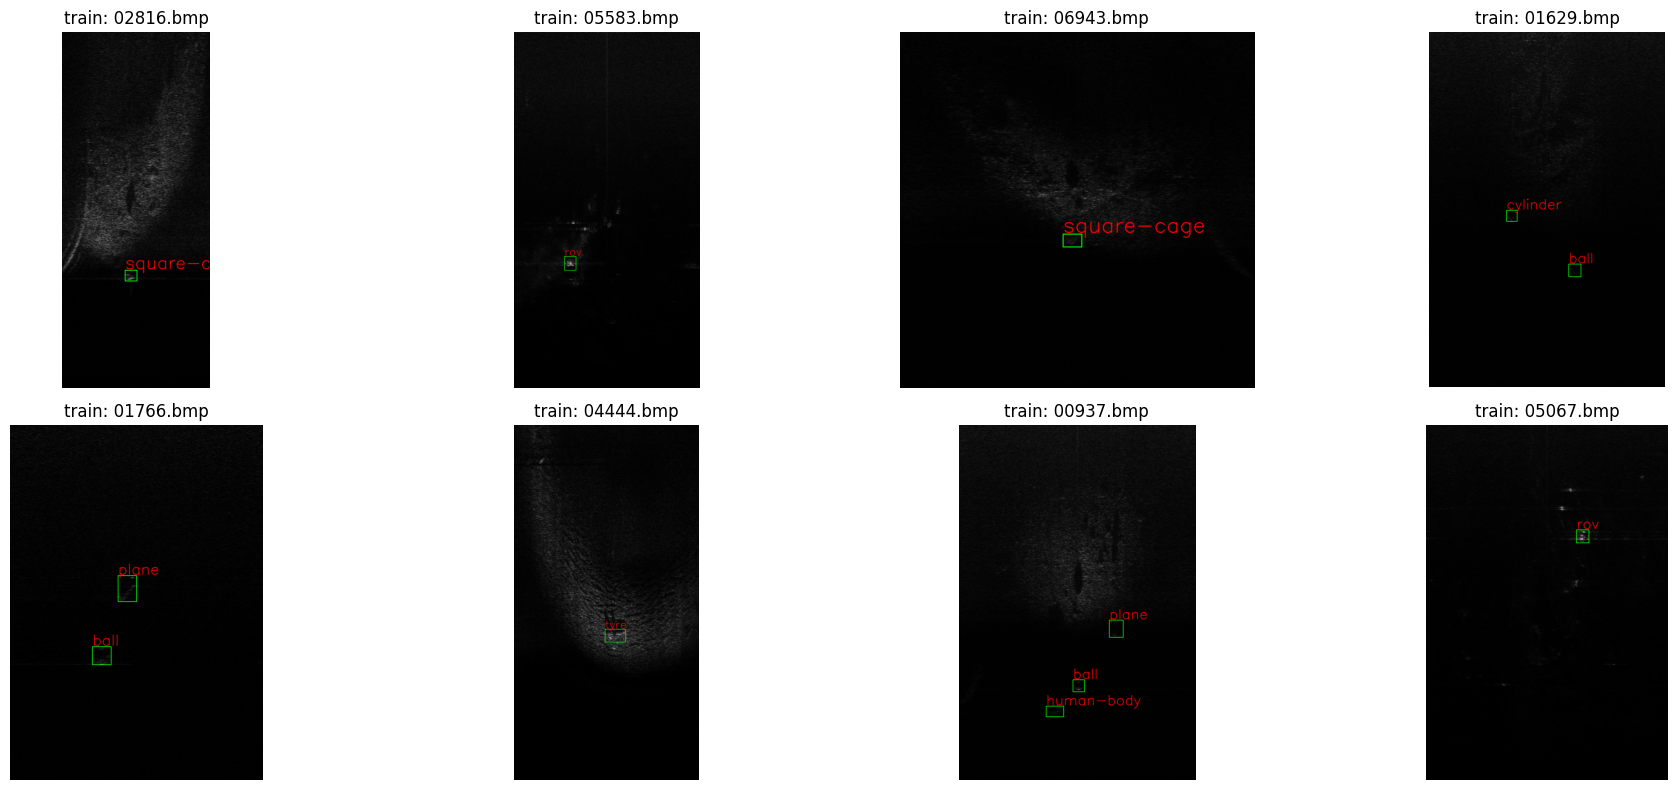

In [15]:
import os, math, random, re
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import yaml

# ---------------- config ----------------
DATA_ROOT = Path("data/UATD")
IMG_ROOT  = DATA_ROOT / "images"
LAB_ROOT  = DATA_ROOT / "labels"

SPLIT = "train"   # "train", "val", or "test"
IMG_DIR = IMG_ROOT / SPLIT
LAB_DIR = LAB_ROOT / SPLIT

NUM_PICS = 8
COLS = 4

# Try to read class names from data/UATD/uatd.yaml; fall back to a default list
NAMES = None
yaml_path = DATA_ROOT / "uatd.yaml"
if yaml_path.exists():
    try:
        y = yaml.safe_load(yaml_path.read_text())
        if isinstance(y.get("names"), list):
            NAMES = y["names"]
        elif isinstance(y.get("names"), dict):
            # sort by numeric key (0..n-1)
            NAMES = [name for _, name in sorted(y["names"].items(), key=lambda kv: int(kv[0]))]
    except Exception as e:
        print("Warning: could not parse names from uatd.yaml:", e)

if not NAMES:
    # Fallback UATD names (lowercase, hyphenated to match our earlier converters)
    NAMES = [
        "cube","ball","cylinder","human-body","plane",
        "circle-cage","square-cage","metal-bucket","tyre","rov"
    ]
# ----------------------------------------

def find_images(folder: Path):
    exts = (".jpg",".jpeg",".png",".bmp",".tif",".tiff")
    return [p for p in folder.rglob("*") if p.suffix.lower() in exts]

def label_path_for(img_path: Path) -> Path:
    return LAB_DIR / (img_path.stem + ".txt")

def draw_yolo_labels(image_bgr, label_file: Path, names):
    img = image_bgr.copy()
    h, w = img.shape[:2]
    if not label_file.exists():
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for line in label_file.read_text().splitlines():
        line = line.strip()
        if not line:
            continue
        # YOLO format: class cx cy w h (normalized 0..1)
        parts = re.split(r"\s+", line)
        if len(parts) < 5:
            continue
        cls = int(float(parts[0]))
        cx, cy, bw, bh = map(float, parts[1:5])

        x1 = int((cx - bw/2) * w); y1 = int((cy - bh/2) * h)
        x2 = int((cx + bw/2) * w); y2 = int((cy + bh/2) * h)
        x1 = max(0, min(w-1, x1)); y1 = max(0, min(h-1, y1))
        x2 = max(0, min(w-1, x2)); y2 = max(0, min(h-1, y2))

        color = (0,255,0)  # green box
        cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
        label = names[cls] if 0 <= cls < len(names) else f"id{cls}"
        cv2.putText(img, label, (x1, max(0, y1-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2, cv2.LINE_AA)  # red text
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# collect images that exist (prefer ones with labels)
all_imgs = find_images(IMG_DIR)
imgs_with_labels = [p for p in all_imgs if label_path_for(p).exists()]
pool = imgs_with_labels if imgs_with_labels else all_imgs

if not pool:
    raise FileNotFoundError(f"No images found in {IMG_DIR}")

sample_ids = random.sample(pool, min(NUM_PICS, len(pool)))
rows = math.ceil(len(sample_ids) / COLS)

plt.figure(figsize=(5*COLS, 4*rows))
for idx, img_path in enumerate(sample_ids, 1):
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        continue
    lab_path = label_path_for(img_path)
    vis = draw_yolo_labels(img_bgr, lab_path, NAMES)

    plt.subplot(rows, COLS, idx)
    plt.imshow(vis)
    plt.axis("off")
    plt.title(f"{SPLIT}: {img_path.name}")
plt.tight_layout()
plt.show()
